In [20]:
%pylab inline --no-import-all
import math
import george
import numpy as np
import scipy.optimize as so
import scipy.stats as ss
import scipy.special as ssp
import time
from iminuit import Minuit
import ROOT as r
import matplotlib.ticker as ticker
import matplotlib.cm as cmap
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt
from george.kernels import ExpSquaredKernel

Populating the interactive namespace from numpy and matplotlib


### Load the data histogram: Saved as arrays in InitialFits

In [62]:
ycounts = np.load("ycounts.npy")
yerrs = np.load("yerrs.npy")
xbins = np.load("xbins.npy")
xerrs = np.load("xerrs.npy")
toyData = np.load("toys.npy")
fixedHyperparameters = np.load("fixedHyperparameters.npy")

standardParamSets = [(500, 3000, 250), (100, 3500, 250), (75, 4000, 250), 
             (50, 4500, 250), (35, 5000, 250), (20,5500, 250), (15, 6000,250)]

### Useful functions

#### Gausian function to use as a signal

In [4]:
def sig_model(x, N=1e5, mass=2000., width=100.):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*np.append(np.diff(x),np.diff(x)[-1])

#### Calculate the z-val and chi squared fit between data and fit. The signficance is plotted in the bottom panel of makePrettyPlots

In [5]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

#### Poisson likelihood

In [6]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

#### Non central chi squared to fit to log likelihood ratio 

In [49]:
def ncchi(x, nc):
    return ss.ncx2.pdf(x, 1., nc) 

#### Distribution of log likelihood ratio. Can draw on a chi squared when looking at the ratio with no signal added (since we expect the distribution of our test statistic with one additional signal parameter to follow a chi squared), or you can fit for a non central chi squared when there is a signal added.

In [50]:
def makePrettyPlots_LLH(GP_LLH, title, drawchi2=False, drawNCchi2=False, xname=r'$\chi^{2}$'):
    f, (ax1) = plt.subplots(1, figsize=(10,5))
    f.suptitle(title, fontsize=20)

    lowx = 0
    highx = max(GP_LLH)+1
    
    bins = np.linspace(lowx, highx, 100)
    dx = bins[1]-bins[0]
    bin_centers = bins[:-1] + dx/2.
    hGP, _, _ = ax1.hist(GP_LLH, bins=bins, color="b")
    #print hGP
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    #ax1.set_title(label, fontsize=20)
    ax1.set_xlabel(xname, fontsize=20)
    if drawchi2:
        chi2_gp = sum(hGP)*(bins[1]-bins[0])*ss.chi2.pdf(bin_centers, 1.)
        ax1.plot(bin_centers, chi2_gp, c='r', linewidth=2)
    if drawNCchi2:
        best_fit_params, _ = so.curve_fit(ncchi, bin_centers, hGP)
        print "nc ", best_fit_params
        nc_chi = sum(hGP)*dx*ss.ncx2.pdf(bin_centers, 1., best_fit_params[0]) 
        ax1.plot(bin_centers, nc_chi, c='r', linewidth=3)
    
    plt.show()

### Mean of the Gaussian Process - 3 parameter dijet fit function

In [9]:
from george.modeling import ModelingMixin
class Mean(ModelingMixin):
    def get_value(self, t):
        sqrts = 13000.
        return (self.p0 * (1.-t/sqrts)**self.p1 * (t/sqrts)**(self.p2))*np.append(np.diff(t), np.diff(t)[-1])

### Log likelihood with a signal strength term added. The likelihood is a built in Gaussian likelihood in george. Then call minuit to minimize the likelihood. Minuit is only fitting for the signal strength parameter - all other hyperparameters (mean and kernel) are kept fixed from the initial GP fit to data

In [53]:
class logLike_gp:
    def __init__(self, x, y, sigTemp):
        self.x = x
        self.y = y
        self.sigTemp = sigTemp
    def __call__(self, N):
        Amp, length, p0, p1, p2 = fixedHyperparameters
        kernel = Amp*ExpSquaredKernel(length)
        gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y-N*self.sigTemp)
        except:
            return np.inf        
        
def fit_gp(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, 
                   N = init0, error_N = 1e-4, limit_N = (0, 100)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

In [63]:
btime=time.time()

LLHR_GP_noSignal={}
LLHR_GP_withSignal={}
for pSet in standardParamSets:
    n, m, w = pSet
    print pSet
    LLHR_GP_noSignal[m]=[]
    LLHR_GP_withSignal[m]=[]

    for itoy, toy in enumerate(toyData):
        if not itoy%100: 
            print itoy
                
        signalTemplate = np.random.poisson(np.round(sig_model(xbins, n, m, w)))
        dataPlusSignal = ycounts+signalTemplate
        Amp, length, p0, p1, p2 = fixedHyperparameters
        kernel = Amp*ExpSquaredKernel(length)
        
        #############################################################################
        #BACKGROUND ONLY FIT TO DATA ONLY
        if itoy==0:
            pgpb_stime = time.time()
                
        gp_bkg = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp_bkg.compute(xbins, yerrs)
        MAP_bkg, covGP_bkg = gp_bkg.predict(ycounts, xbins)
        LLH_bkg = gp_bkg.lnlikelihood(ycounts)
            
        if itoy==0:
            pgpb_etime = time.time()
            print "background only time:", pgpb_etime-pgpb_stime
        #############################################################################
        #BACKGROUND ONLY FIT TO DATA+SIGNAL ONLY
        if itoy==0:
            pgpb_stime = time.time()
                
        gp_bkg_sd = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp_bkg_sd.compute(xbins, yerrs)
        MAP_bkg_sd, covGP_bkg_sd = gp_bkg_sd.predict(dataPlusSignal, xbins)
        LLH_bkg_sd = gp_bkg_sd.lnlikelihood(dataPlusSignal)
            
        if itoy==0:
            pgpb_etime = time.time()
            print "background only time:", pgpb_etime-pgpb_stime
        #############################################################################
        

        #############################################################################        
        #BACKGROUND+SIGNAL FIT GP
        if itoy==0:
            pgpsb_stime = time.time()

        lnProb = logLike_gp(xbins, ycounts, signalTemplate)
        minLLH, best_fit_gp = fit_gp(lnProb, False)
        if np.isinf(minLLH): continue
        signal_strength = best_fit_gp[0]
        gp_sigbkg = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp_sigbkg.compute(xbins, yerrs)
        MAP, covGP = gp_sigbkg.predict(ycounts - signal_strength*signalTemplate, xbins)
        MAP_sigbkg = MAP+signal_strength*signalTemplate
        LLH_sigbkg = gp_sigbkg.lnlikelihood(ycounts - signal_strength*signalTemplate)

        if itoy==0:
            pgpsb_etime = time.time()
            print "background + signal time:", pgpsb_etime - pgpsb_stime
        
        LLHR_GP_noSignal[m].append(-2*(LLH_bkg-LLH_sigbkg))
        #############################################################################    
            
        #BACKGROUND+SIGNAL FIT GP ON DATA+SIGNAL
        if itoy==0:
            pgpsb_sd_stime = time.time()

        lnProb = logLike_gp(xbins, ycounts+signalTemplate, signalTemplate)
        minLLH, best_fit_gp = fit_gp(lnProb, False)
        if np.isinf(minLLH): continue
        signal_strength_sd = best_fit_gp[0]
        gp_sigbkg_sd = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp_sigbkg_sd.compute(xbins, yerrs)
        MAP, covGP = gp_sigbkg_sd.predict(ycounts+signalTemplate - signal_strength*signalTemplate, xbins)
        MAP_sigbkg_sd = MAP+signal_strength*signalTemplate
        LLH_sigbkg_sd = gp_sigbkg_sd.lnlikelihood(ycounts+signalTemplate - signal_strength*signalTemplate)

        if itoy==0:
            pgpsb_etime = time.time()
            print "background + signal time:", pgpsb_etime - pgpsb_stime
        
        LLHR_GP_withSignal[m].append(-2*(LLH_bkg_sd-LLH_sigbkg_sd))


etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"  

(500, 3000, 250)
0
background only time: 0.00838685035706
background only time: 0.00165796279907
background + signal time: 0.0300581455231
background + signal time: 0.0770750045776
100
200
300
400
500
600
700
800
900
(100, 3500, 250)
0
background only time: 0.00199103355408
background only time: 0.00156021118164
background + signal time: 0.0291469097137
background + signal time: 0.0532119274139
100
200
300
400
500
600
700
800
900
(75, 4000, 250)
0
background only time: 0.00205612182617
background only time: 0.00172901153564
background + signal time: 0.0247428417206
background + signal time: 0.0688538551331
100
200
300
400
500
600
700
800
900
(50, 4500, 250)
0
background only time: 0.00181913375854
background only time: 0.00155305862427
background + signal time: 0.0196301937103
background + signal time: 0.0493700504303
100
200
300
400
500
600
700
800
900
(35, 5000, 250)
0
background only time: 0.00192880630493
background only time: 0.00155591964722
background + signal time: 0.0374670028

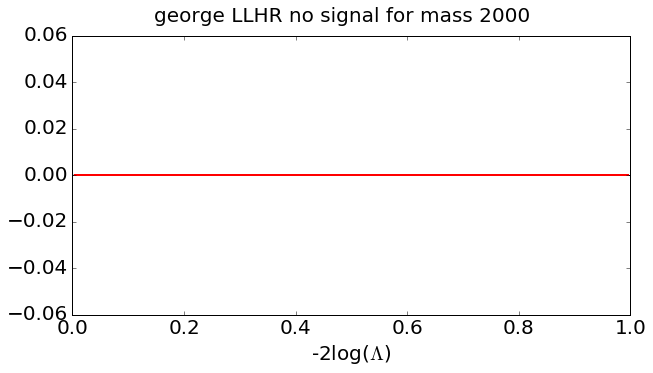

nc  [  6.57551692e-06]


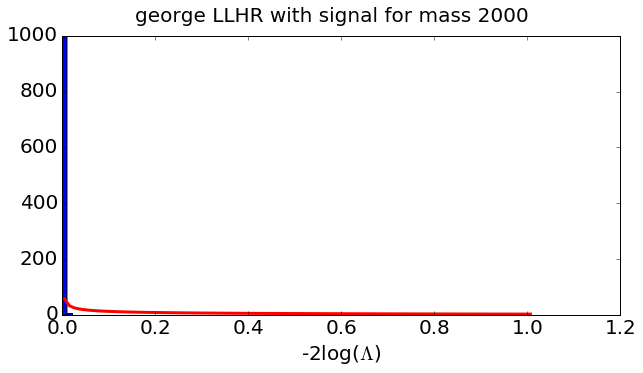

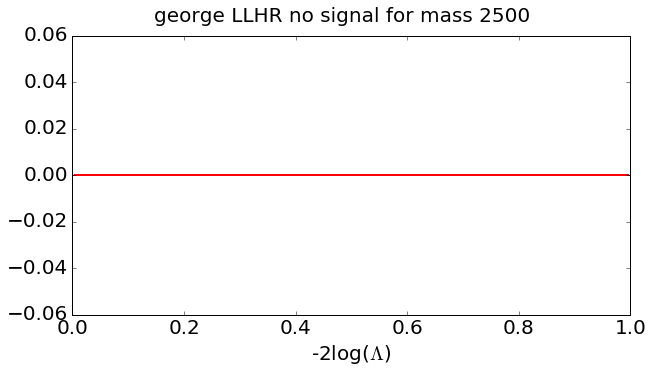

nc  [  9.07885108e-07]


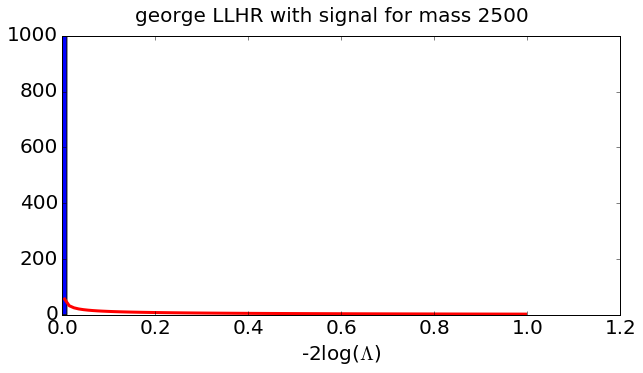

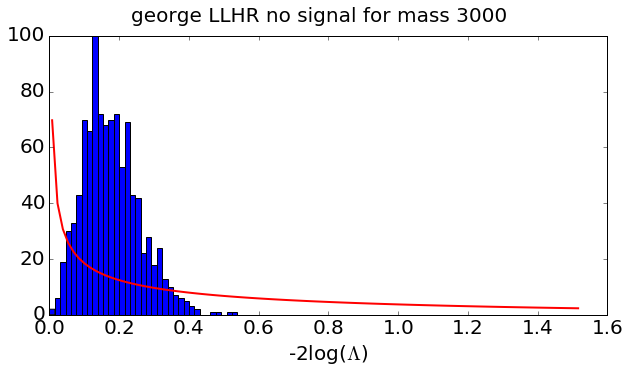

nc  [ 4.92102509]


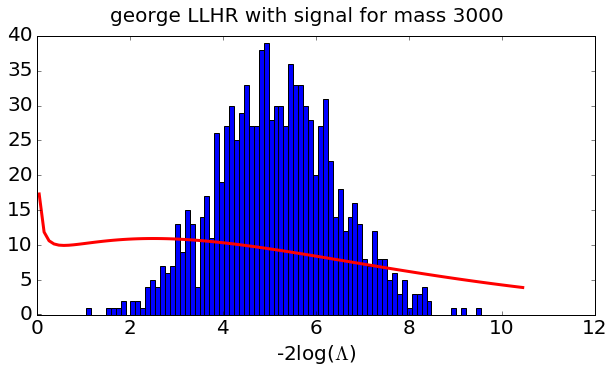

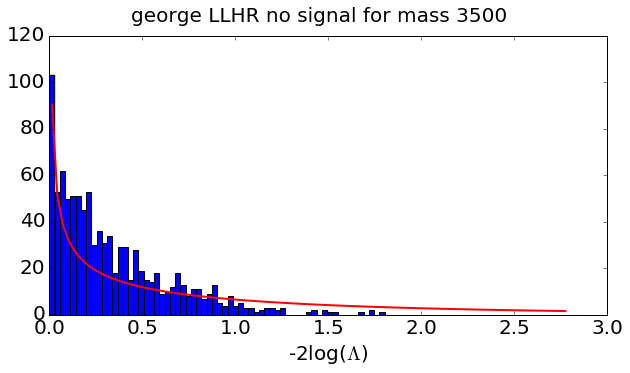

nc  [  3.87710468e-05]


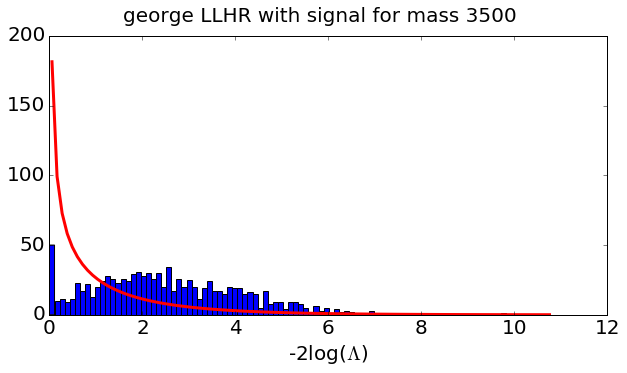

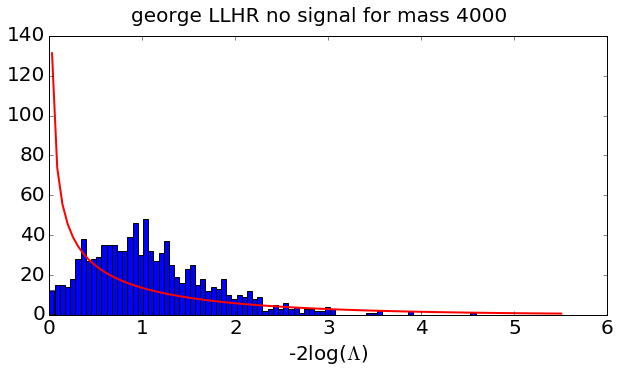

nc  [ 6.00685384]


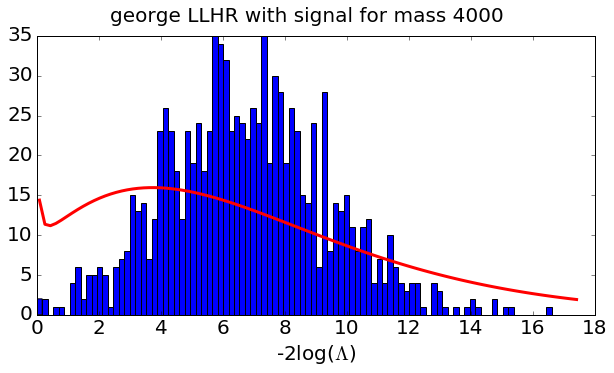

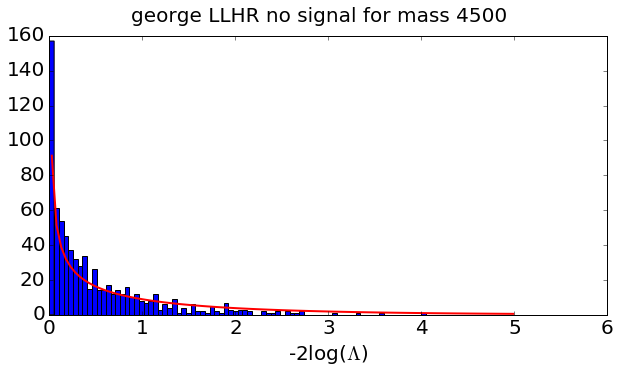

nc  [  2.22044605e-16]


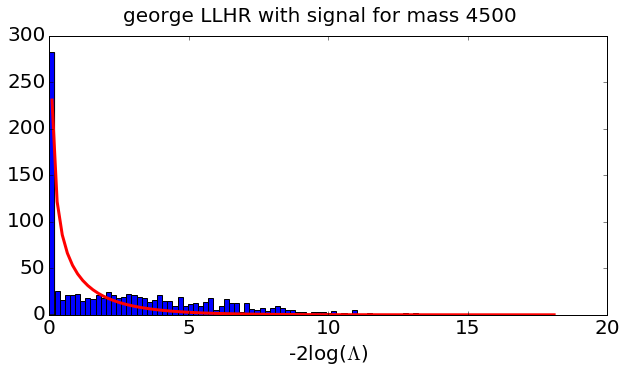

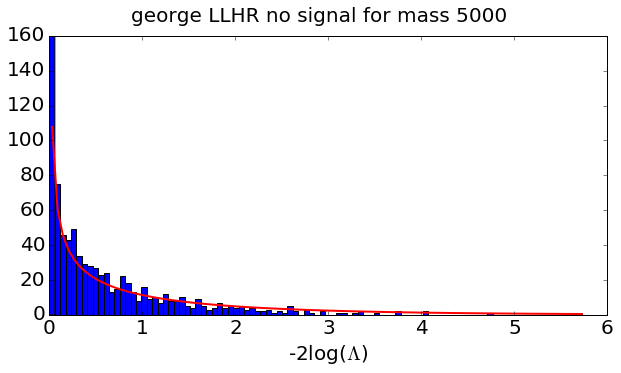

nc  [  2.22044605e-16]


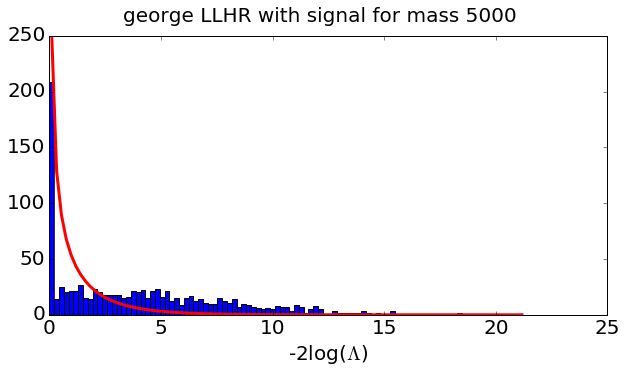

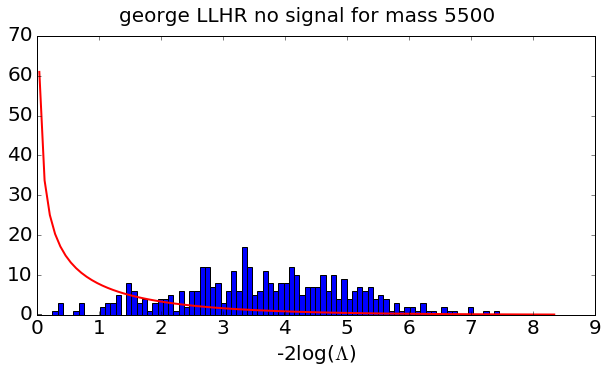

nc  [  1.53904071e-05]


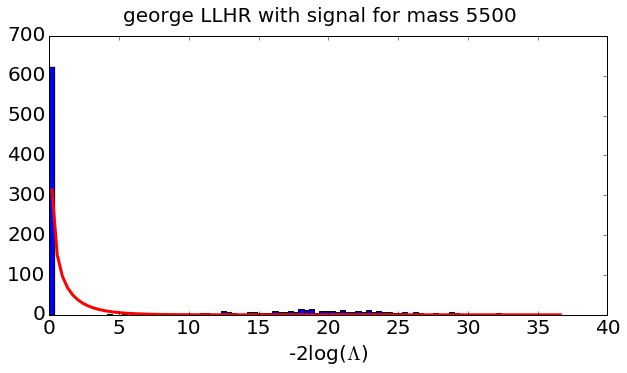

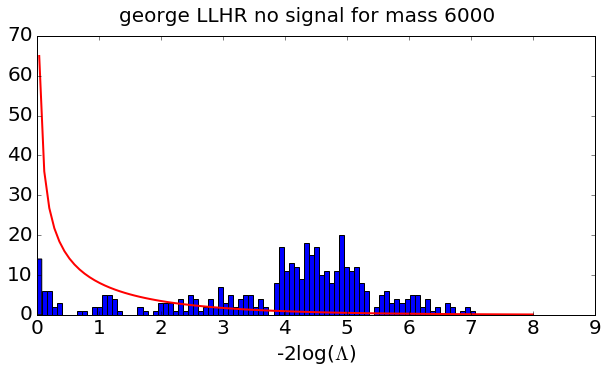

nc  [ 7.59227891]


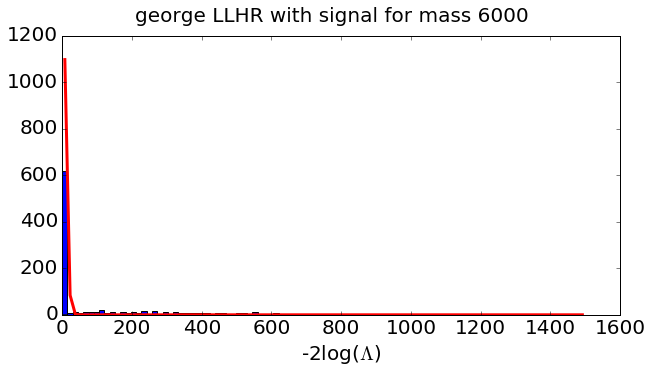

In [61]:
GP_meanLLHR_noSignal=[]
GP_meanLLHR_withSignal=[]
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
for m in msignals:
    gp_LLH_noSignal = [ll for ll in LLHR_GP_noSignal[m] if not (np.isinf(ll) or np.isnan(ll))]
    gp_LLH_withSignal = [ll for ll in LLHR_GP_withSignal[m] if not (np.isinf(ll) or np.isnan(ll))]
    
    #gp_neg_frac = round(100.*sum(i < 0 for i in gp_LLH_noSignal)/len(gp_LLH_noSignal),2)
    #print "george % < 0: ", gp_neg_frac
    #gp_neg_frac_non0 = round(100.*sum(i < -1 for i in gp_LLH_noSignal)/len(gp_LLH_noSignal),2)
    #print "george % < -1: ", gp_neg_frac_non0
    
    GP_meanLLHR_noSignal.append([np.median(np.array(gp_LLH_noSignal)), np.std(np.array(gp_LLH_noSignal))])
    GP_meanLLHR_withSignal.append([np.median(np.array(gp_LLH_withSignal)), np.std(np.array(gp_LLH_withSignal))])

    label = "george LLHR no signal for mass "+str(int(m))
    makePrettyPlots_LLH(gp_LLH_noSignal, label, drawchi2=True, drawNCchi2=False, xname = r"-2log($\Lambda$)")

    label = "george LLHR with signal for mass "+str(int(m))
    makePrettyPlots_LLH(gp_LLH_withSignal, label, drawchi2=False, drawNCchi2=True, xname = r"-2log($\Lambda$)")

